# What Makes a Star - Supervised Learning Strategy 

NBA players can be grouped into different categories; prospect, role player, and star. Stars and seem to have an intangible quality that distinguish them from other players. Maybe that special attribute is their stats. Or maybe, it is leadership and team success. Could it be popularity? Or maybe it is something else entirely. We will find out with a data science and machine learning approach.      

## Imports and Common Functions 

Python packages are imported for deep learning and machine learning analysis. Functions used in the analysis are also added. 

In [1]:
# !pip install matplotlib seaborn scikit-learn tensorflow 
import pandas as pd, numpy as np, sklearn as sklm
import matplotlib.pyplot as plt, seaborn as sns 
import tensorflow as tf, gradio 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 25)

import sqlalchemy, sqlite3   
from sklearn.linear_model import LogisticRegression, LinearRegression 
from sklearn.metrics import accuracy_score 

import sys, os    
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('functions.py'), '..', '..', 'PY')))
import functions 
# from functions import generate_seasons 
# import Functions
# # import Functions
# functions

In [2]:
def combine_dfs(dfs):
    master = dfs[0]
    for i in range(1, len(dfs)):
        cols_new = dfs[i].columns.difference(master.columns).tolist() 
        cols_new.append('Player') 
        master = pd.merge(master, dfs[i][cols_new], on="Player") 
    return master 

def clean_player(name): 
    i = name.find('*') 
    clean_name = name 
    if i > -1: 
        clean_name = clean_name[:i] 
    return clean_name 

## Dataset/Preprocessing 
A dataset with 19374 rows and 67 columns is loaded into the workspace. This includes player data starting from the 1979-80 season, since this is the season that the 3 points line was introduced. Each row represents an individual player's season, and each column represents a statistic. 
Statistics include per-game averages such as points per game, totals such as the number of games played, and advanced stats such as usage percentage. 
Each observation of a player's season includes a label that indicated whether or not the player was an all-star during the given season. 
This is the data that will be used to train and evaluate the all-star prediction models. 

In [3]:
db_path = "sqlite:///../../DB/ballbase.db" 

engine = sqlalchemy.create_engine(db_path) 
seasons = functions.generate_seasons(1979, 2024) 
master = pd.DataFrame() 
ssn = pd.DataFrame() 

for season in seasons: 
    master_temp = pd.read_sql("master_" + season, con=engine).drop(['Tm', 'GS', 'Pos'], axis=1).fillna(0) 
    master_temp.insert(1, "Season", [season]*len(master_temp), True) 
    master_temp['Season'] = season.replace('_', '-') 

    master = pd.concat([master, master_temp], axis=0) 

allstars = pd.read_sql('allstars', con=engine) 

master = master if 'AS' in master.columns else master.merge(allstars, how='left', on=['Player', 'Season']) 
master = master.rename(columns = {'Status':'AS'}) 
master['AS'] = master['AS'].apply(lambda x: False if pd.isna(x) else True)
master['AS'] = master['AS'].astype("float64")

numeric_df = master[master['Season']!='2023-24'] 
numeric_df = numeric_df.select_dtypes(include = [np.number])  
numeric_df 
master

,Player,Season,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,T2P,T2PA,T3PA,TAST,TBLK,TDRB,TFG,TFGA,TFT,TFTA,TMP,TORB,TPF,TPTS,TSTL,TTOV,TTRB,DRtg,ORtg,3PAr,AST%,BLK%,BPM,DBPM,DRB%,DWS,FTr,OBPM,ORB%,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,AS
0,Abdul Jeelani,1979-80,25.0,77.0,16.7,3.7,7.3,0.510,0.0,0.1,0.000,3.7,7.3,0.515,0.510,2.1,2.6,0.789,1.5,2.0,3.5,1.2,0.5,0.5,1.5,2.0,9.6,288.0,559.0,6.0,95.0,40.0,156.0,288.0,565.0,161.0,204.0,1286.0,114.0,155.0,737.0,40.0,117.0,270.0,104.0,109.0,0.011,11.6,1.8,1.5,-0.1,13.5,1.5,0.361,1.7,9.6,2.3,18.7,1.5,15.2,11.5,0.563,24.6,1.1,3.8,0.141,0.0
1,Adrian Dantley,1979-80,24.0,68.0,39.3,10.7,18.6,0.576,0.0,0.0,0.000,10.7,18.6,0.577,0.576,6.5,7.7,0.842,2.7,4.9,7.6,2.8,1.4,0.2,3.4,3.1,28.0,730.0,1265.0,2.0,191.0,14.0,333.0,730.0,1267.0,443.0,526.0,2674.0,183.0,211.0,1903.0,96.0,233.0,516.0,110.0,119.0,0.002,12.3,0.3,3.7,-1.6,14.0,1.1,0.415,5.3,8.3,9.5,24.3,1.8,13.5,11.3,0.635,27.8,3.8,10.5,0.189,1.0
2,Al Skinner,1979-80,27.0,2.0,5.0,0.5,1.0,0.500,0.0,0.0,0.000,0.5,1.0,0.500,0.500,0.0,0.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,1.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,10.0,0.0,1.0,2.0,0.0,2.0,0.0,111.0,65.0,0.000,25.4,0.0,-4.8,-0.2,0.0,0.0,0.000,-4.6,0.0,0.0,-0.6,0.0,50.0,0.0,0.500,16.0,0.0,0.0,-0.152,0.0
3,Alex English,1979-80,26.0,78.0,30.8,7.1,14.3,0.497,0.0,0.1,0.333,7.1,14.2,0.498,0.498,2.7,3.4,0.789,3.4,4.3,7.8,2.9,0.9,0.8,2.7,2.6,16.9,551.0,1107.0,6.0,224.0,62.0,336.0,553.0,1113.0,210.0,266.0,2401.0,269.0,206.0,1318.0,73.0,214.0,605.0,107.0,106.0,0.005,13.9,1.4,0.4,-1.2,14.9,2.0,0.239,1.6,11.3,3.3,18.0,1.4,14.8,13.1,0.536,23.4,1.5,5.3,0.105,0.0
4,Allan Bristow,1979-80,28.0,82.0,28.1,4.6,9.6,0.480,0.0,0.1,0.286,4.6,9.5,0.482,0.482,2.4,3.0,0.811,2.1,4.2,6.2,4.2,1.1,0.1,2.2,2.6,11.6,375.0,778.0,7.0,341.0,6.0,342.0,377.0,785.0,197.0,243.0,2304.0,170.0,211.0,953.0,88.0,179.0,512.0,110.0,108.0,0.009,21.4,0.1,0.6,-0.8,16.7,1.2,0.310,1.4,9.0,3.2,16.6,1.9,16.7,13.0,0.534,20.0,1.5,4.4,0.091,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,Zach LaVine,2023-24,28.0,25.0,34.9,6.8,15.0,0.452,2.4,6.8,0.349,4.4,8.3,0.536,0.531,3.5,4.1,0.854,0.3,4.8,5.2,3.9,0.8,0.3,2.1,2.3,19.5,111.0,207.0,169.0,98.0,8.0,121.0,170.0,376.0,88.0,103.0,872.0,8.0,57.0,487.0,21.0,52.0,129.0,118.0,113.0,0.449,16.8,0.9,0.1,-0.7,15.8,0.6,0.274,0.8,1.0,0.8,15.1,1.2,11.0,8.3,0.578,23.8,0.5,1.5,0.080,0.0
19371,Zavier Simpson,2023-24,26.0,7.0,23.0,2.4,7.7,0.315,0.7,2.4,0.294,1.7,5.3,0.324,0.361,0.4,0.6,0.750,0.6,2.3,2.9,3.6,1.0,0.4,1.4,1.6,6.0,12.0,37.0,17.0,25.0,3.0,16.0,17.0,54.0,3.0,4.0,161.0,4.0,11.0,42.0,7.0,10.0,20.0,115.0,86.0,0.315,22.5,1.7,-5.9,0.3,11.3,0.2,0.074,-6.2,2.6,-0.3,6.3,2.1,15.2,6.8,0.377,17.5,-0.2,-0.2,-0.046,0.0
19372,Zeke Nnaji,2023-24,23.0,58.0,9.9,1.2,2.6,0.463,0.1,0.4,0.261,1.1,2.2,0.500,0.483,0.7,1.1,0.677,1.1,1.1,2.2,0.6,0.3,0.7,0.5,1.4,3.2,63.0,126.0,23.0,32.0,38.0,65.0,69.0,149.0,42.0,62.0,576.0,61.0,81.0,186.0,15.0,27.0,126.0,112.0,113.0,0.154,7.0,5.6,-3.7,0.1,12.2,0.8,0.416,-3.8,12.1,0.4,12.4,1.3,13.3,12.1,0.528,15.4,-0.2,1.2,0.099,0.0
19373,Ziaire Williams,2023-24,22.0,51.0,20.4,2.9,7.4,0.397,1.1,3.7,0.307,1.8,3.7,0.487,0.474,1.2,1.5,0.827,0.7,2.8,3.5,1.5,0.7,0.2,1.3,1.7,8.2,92.0,189.0,189.0,75.0,9.0,145.0,150.0,378.0,62.0,75.0,1038.0,35.0,85.0,420.0,36.0,66.0,180.0,115.0,98.0,0.500,11.1,0.8,-4.5,-0.4,15.9,1.1,0.198,-4.0,3.5,-0.9,9.3,1.7,13.8,9.5,0.511,19.7,-0.6,0.2,0.010,0.0


In [4]:
X_train, X_test, y_train, y_test = sklm.model_selection.train_test_split(numeric_df.drop('AS', axis=1), numeric_df['AS'], test_size=0.2, random_state=1) 

## Models

The models learn patterns from the data to make predictions on the desired output. In this case, the desired output is whether or not the  player is an all-star. They all take different strategies to learn from the data, but ultimately have the same goal. All of these models use supervised learning approches, meaning that the training data has input and output examples. The 3 model types include logistic regression, neural network, and random forest model types. 

### Logistic Regression Model 

A logistic regression model predicts a variable with only 2 possible values. In this case, the prediction is whether or not a player is an allstar. 

In [5]:
X_train, X_test, y_train, y_test = sklm.model_selection.train_test_split(numeric_df.drop('AS', axis=1), numeric_df['AS'], test_size=0.2, random_state=1) 
lr_model = LogisticRegression(fit_intercept=True, solver='lbfgs') 
lr_model.fit(X_train, y_train)

C:\Users\bchan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [6]:
train_accuracy = sklm.metrics.accuracy_score(y_train, lr_model.predict(X_train))
print(f"Train Accuracy: {train_accuracy}") 

test_accuracy = sklm.metrics.accuracy_score(y_test, lr_model.predict(X_test))
print(f"Test Accuracy {test_accuracy}") 

Train Accuracy: 0.9683552719053318
Test Accuracy 0.9699547992555172


### Neural Network Sequential Model 
The neural network learns from the data and determines the importance of each stat in predicting all-stars on its own. It uses the weighted features to output a probability that a player is an all-star. 

In [7]:
numeric_tensor = tf.convert_to_tensor(numeric_df.drop('AS', axis=1) )  
normalizer = tf.keras.layers.Normalization(axis=-1) 
normalizer.adapt(numeric_tensor) 

In [8]:
X_train, X_test, y_train, y_test = sklm.model_selection.train_test_split(numeric_df.drop('AS', axis=1), numeric_df['AS'], test_size=0.2, random_state=2)  
seq_model = tf.keras.Sequential() 
seq_model.add(normalizer) 
seq_model.add(tf.keras.layers.Dense(units=10, activation='relu')) 
seq_model.add(tf.keras.layers.Dense(units=10, activation='relu')) 
seq_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  

seq_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
history = seq_model.fit(tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train), epochs=10, batch_size=1, validation_split=0.1) 

Epoch 1/10
13537/13537 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9420 - loss: 0.1483 - val_accuracy: 0.9748 - val_loss: 0.0644
Epoch 2/10
13537/13537 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.9654 - loss: 0.0837 - val_accuracy: 0.9668 - val_loss: 0.0691
Epoch 3/10
13537/13537 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9652 - loss: 0.0820 - val_accuracy: 0.9708 - val_loss: 0.0658
Epoch 4/10
13537/13537 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.9681 - loss: 0.0738 - val_accuracy: 0.9714 - val_loss: 0.0754
Epoch 5/10
13537/13537 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9686 - loss: 0.0747 - val_accuracy: 0.9734 - val_loss: 0.0646
Epoch 6/10
13537/13537 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9661 - loss: 0.0773 - val_accuracy: 0.9741 - val_loss: 0.0613
Epoch 7/10
13537/13537 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9687 - loss: 0.0725 - val_accuracy: 0.9761 - val_loss: 0.0637
Epoch 8/10
13537/13537 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 

In [9]:
test_loss, test_accuracy = seq_model.evaluate(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test))   
print(f'Test Accuracy: {test_accuracy}') 

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.9720 - loss: 0.0729
Test Accuracy: 0.9678276777267456


### Random Forest Model 
The random forest model consists of a group of 200 decison trees, and makes predictions based off the outcome of the decision trees. 
Each decision tree consists of many splits (ex. points per game above or below 20 ppg), and makes the final decision based on the splits. 

In [10]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = sklm.model_selection.train_test_split(numeric_df.drop('AS', axis=1), numeric_df['AS'], test_size=0.2, random_state=3) 
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, max_features='sqrt', min_samples_split=10, min_samples_leaf=5, bootstrap=True)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200)

In [11]:
rf_train_pred = rf_model.predict(X_train) 
rf_test_pred = rf_model.predict(X_test) 

rf_train_acc = accuracy_score(y_train, rf_train_pred) 
rf_test_acc = accuracy_score(y_test, rf_test_pred) 
# rf_train_acc  
rf_test_acc

0.9710183461845254

### Ensemble Model 
The ensemble model uses the 3 models (logistic regression, neural network, and random forest) to form the final all-star prediction as the most common prediction of the models. 

In [12]:
def predict_ensemble(row): 
    example = master[(master['Player']==row['Player']) & (master['Season']==row['Season'])] 
    example = pd.DataFrame(example)
    example = example.drop(['AS', 'Player', 'Season'], axis=1) 
    # example = example.select_dtypes(include=[np.number]).drop('AS', axis=1) 
    row['AS'] = int(row['AS'])
    row['LRPRED'] = int(lr_model.predict(example)[0])  
    row['NNPRED'] = int(seq_model.predict(tf.convert_to_tensor(example))[0][0] > 0.5) 
    row['RFPRED'] = int(rf_model.predict(example)[0]) 

    row['ENSPRED'] = int((row['LRPRED'] + row['NNPRED'] + row['RFPRED']) >= 2) 
    return row 
    

### Testing on the 2023-24 Season 
The 2023-24 season was not used to train the models, so it serves as a good set to test the them. 

In [13]:
s_24 = master[master['Season']=='2023-24'] 
s_24 = s_24.apply(lambda x: predict_ensemble(x), axis=1)  
s_24['']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

,Player,Season,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,T2P,T2PA,T3PA,TAST,TBLK,TDRB,TFG,TFGA,TFT,TFTA,TMP,TORB,TPF,TPTS,TSTL,TTOV,TTRB,DRtg,ORtg,3PAr,AST%,BLK%,BPM,DBPM,DRB%,DWS,FTr,OBPM,ORB%,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,AS,LRPRED,NNPRED,RFPRED,ENSPRED
18803,A.J. Green,2023-24,24.0,56.0,11.0,1.5,3.5,0.423,1.2,3.0,0.408,0.3,0.5,0.519,0.599,0.3,0.3,0.895,0.2,1.0,1.1,0.5,0.2,0.1,0.2,0.9,4.5,14.0,27.0,169.0,30.0,4.0,55.0,83.0,196.0,17.0,19.0,614.0,9.0,49.0,252.0,9.0,12.0,64.0,120.0,122.0,0.862,6.4,0.6,-2.1,-1.7,9.6,0.3,0.097,-0.4,1.6,0.7,10.5,0.7,5.5,5.7,0.617,15.2,0.0,1.1,0.084,0,0,0,0,0
18804,A.J. Lawson,2023-24,23.0,42.0,7.4,1.3,2.9,0.446,0.3,1.2,0.260,1.0,1.7,0.577,0.500,0.4,0.5,0.652,0.3,0.9,1.2,0.5,0.2,0.1,0.3,0.5,3.2,41.0,71.0,50.0,20.0,3.0,36.0,54.0,121.0,15.0,23.0,311.0,14.0,22.0,136.0,10.0,14.0,50.0,117.0,105.0,0.413,8.9,0.8,-4.6,-1.5,12.6,0.3,0.190,-3.1,4.9,0.0,11.2,1.5,9.6,8.8,0.519,20.0,-0.2,0.2,0.036,0,0,0,0,0
18805,AJ Griffin,2023-24,20.0,20.0,8.6,0.9,3.1,0.290,0.5,2.0,0.256,0.4,1.2,0.348,0.371,0.1,0.1,1.000,0.1,0.8,0.9,0.3,0.1,0.1,0.4,0.3,2.4,8.0,23.0,39.0,5.0,2.0,16.0,18.0,62.0,2.0,2.0,171.0,2.0,6.0,48.0,1.0,8.0,18.0,124.0,77.0,0.629,3.7,1.1,-9.6,-3.5,10.6,0.0,0.032,-6.0,1.2,-0.4,1.2,0.3,11.3,5.7,0.382,17.3,-0.3,-0.4,-0.120,0,0,0,0,0
18806,Aaron Gordon,2023-24,28.0,73.0,31.5,5.5,9.8,0.556,0.5,1.9,0.290,4.9,7.9,0.619,0.584,2.4,3.7,0.658,2.4,4.1,6.5,3.5,0.8,0.6,1.4,1.9,13.9,358.0,578.0,138.0,259.0,45.0,297.0,398.0,716.0,177.0,269.0,2297.0,174.0,142.0,1013.0,56.0,105.0,471.0,114.0,125.0,0.193,15.2,1.7,1.3,0.1,13.9,2.6,0.376,1.2,8.6,4.5,16.8,1.2,11.2,11.4,0.607,17.8,1.9,7.1,0.148,0,0,0,0,0
18807,Aaron Holiday,2023-24,27.0,78.0,16.3,2.4,5.3,0.446,1.1,2.8,0.387,1.3,2.6,0.510,0.547,0.7,0.8,0.921,0.3,1.3,1.6,1.8,0.5,0.1,0.7,1.6,6.6,102.0,200.0,217.0,140.0,6.0,100.0,186.0,417.0,58.0,63.0,1269.0,23.0,125.0,514.0,42.0,53.0,123.0,116.0,117.0,0.520,15.4,0.4,-1.5,0.3,8.5,1.2,0.151,-1.8,1.9,1.3,11.5,1.6,10.6,5.2,0.578,16.7,0.2,2.5,0.094,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,Zach LaVine,2023-24,28.0,25.0,34.9,6.8,15.0,0.452,2.4,6.8,0.349,4.4,8.3,0.536,0.531,3.5,4.1,0.854,0.3,4.8,5.2,3.9,0.8,0.3,2.1,2.3,19.5,111.0,207.0,169.0,98.0,8.0,121.0,170.0,376.0,88.0,103.0,872.0,8.0,57.0,487.0,21.0,52.0,129.0,118.0,113.0,0.449,16.8,0.9,0.1,-0.7,15.8,0.6,0.274,0.8,1.0,0.8,15.1,1.2,11.0,8.3,0.578,23.8,0.5,1.5,0.080,0,0,0,0,0
19371,Zavier Simpson,2023-24,26.0,7.0,23.0,2.4,7.7,0.315,0.7,2.4,0.294,1.7,5.3,0.324,0.361,0.4,0.6,0.750,0.6,2.3,2.9,3.6,1.0,0.4,1.4,1.6,6.0,12.0,37.0,17.0,25.0,3.0,16.0,17.0,54.0,3.0,4.0,161.0,4.0,11.0,42.0,7.0,10.0,20.0,115.0,86.0,0.315,22.5,1.7,-5.9,0.3,11.3,0.2,0.074,-6.2,2.6,-0.3,6.3,2.1,15.2,6.8,0.377,17.5,-0.2,-0.2,-0.046,0,0,0,0,0
19372,Zeke Nnaji,2023-24,23.0,58.0,9.9,1.2,2.6,0.463,0.1,0.4,0.261,1.1,2.2,0.500,0.483,0.7,1.1,0.677,1.1,1.1,2.2,0.6,0.3,0.7,0.5,1.4,3.2,63.0,126.0,23.0,32.0,38.0,65.0,69.0,149.0,42.0,62.0,576.0,61.0,81.0,186.0,15.0,27.0,126.0,112.0,113.0,0.154,7.0,5.6,-3.7,0.1,12.2,0.8,0.416,-3.8,12.1,0.4,12.4,1.3,13.3,12.1,0.528,15.4,-0.2,1.2,0.099,0,0,0,0,0
19373,Ziaire Williams,2023-24,22.0,51.0,20.4,2.9,7.4,0.397,1.1,3.7,0.307,1.8,3.7,0.487,0.474,1.2,1.5,0.827,0.7,2.8,3.5,1.5,0.7,0.2,1.3,1.7,8.2,92.0,189.0,189.0,75.0,9.0,145.0,150.0,378.0,62.0,75.0,1038.0,35.0,85.0,420.0,36.0,66.0,180.0,115.0,98.0,0.500,11.1,0.8,-4.5,-0.4,15.9,1.1,0.198,-4.0,3.5,-0.9,9.3,1.7,13.8,9.5,0.511,19.7,-0.6,0.2,0.010,0,0,0,0,0


In [34]:
len(s_24[s_24['ENSPRED']==s_24['AS']])/len(s_24) 
# len(s_24[s_24['LRPRED']==s_24['AS']])/len(s_24) 
# len(s_24[s_24['NNPRED']==s_24['AS']])/len(s_24) 
# len(s_24[s_24['RFPRED']==s_24['AS']])/len(s_24) 

s_24[s_24['ENSPRED']!=s_24['AS']] 

,Player,Season,Age,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,T2P,T2PA,T3PA,TAST,TBLK,TDRB,TFG,TFGA,TFT,TFTA,TMP,TORB,TPF,TPTS,TSTL,TTOV,TTRB,DRtg,ORtg,3PAr,AST%,BLK%,BPM,DBPM,DRB%,DWS,FTr,OBPM,ORB%,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,AS,LRPRED,NNPRED,RFPRED,ENSPRED
18839,Bam Adebayo,2023-24,26.0,71.0,34.0,7.5,14.3,0.521,0.2,0.6,0.357,7.3,13.7,0.528,0.529,4.1,5.5,0.755,2.2,8.1,10.4,3.9,1.1,0.9,2.3,2.2,19.3,515.0,975.0,42.0,278.0,66.0,578.0,530.0,1017.0,292.0,387.0,2416.0,159.0,159.0,1367.0,81.0,162.0,737.0,109.0,115.0,0.041,18.9,2.7,2.4,1.7,27.3,4.3,0.381,0.8,7.4,2.9,19.8,1.7,12.0,17.3,0.576,24.9,2.7,7.2,0.144,1,1,0,0,0
18927,De'Aaron Fox,2023-24,26.0,74.0,35.9,9.7,20.9,0.465,2.9,7.8,0.369,6.8,13.1,0.522,0.534,4.2,5.7,0.738,0.9,3.7,4.6,5.6,2.0,0.4,2.6,2.6,26.6,506.0,969.0,580.0,418.0,31.0,273.0,720.0,1549.0,312.0,423.0,2659.0,67.0,193.0,1966.0,150.0,194.0,340.0,114.0,113.0,0.374,25.2,1.1,2.7,0.1,11.8,3.2,0.273,2.6,2.8,3.3,20.1,2.7,10.1,7.2,0.567,31.0,3.2,6.5,0.117,0,1,1,1,1
18932,DeMar DeRozan,2023-24,34.0,79.0,37.8,8.2,17.2,0.480,0.9,2.8,0.333,7.3,14.3,0.509,0.507,6.6,7.7,0.853,0.5,3.8,4.3,5.3,1.1,0.6,1.7,2.0,24.0,575.0,1130.0,225.0,421.0,45.0,297.0,650.0,1355.0,522.0,612.0,2989.0,43.0,161.0,1897.0,90.0,135.0,340.0,118.0,122.0,0.166,21.8,1.5,1.8,-0.3,11.3,2.2,0.452,2.1,1.6,7.0,19.7,1.5,7.7,6.4,0.584,25.8,2.8,9.2,0.147,0,1,1,1,1
18952,Domantas Sabonis,2023-24,27.0,82.0,35.7,7.7,13.0,0.594,0.4,1.1,0.379,7.3,12.0,0.613,0.609,3.6,5.1,0.704,3.6,10.1,13.7,8.2,0.9,0.6,3.3,3.0,19.4,601.0,981.0,87.0,673.0,48.0,826.0,634.0,1068.0,292.0,415.0,2928.0,294.0,250.0,1593.0,74.0,272.0,1120.0,112.0,127.0,0.081,33.9,1.5,6.5,2.4,32.3,4.0,0.389,4.0,11.0,8.6,23.2,1.2,17.9,21.4,0.637,22.2,6.2,12.6,0.206,0,1,1,1,1
19068,Jaylen Brown,2023-24,27.0,70.0,33.5,9.0,17.9,0.499,2.1,5.9,0.354,6.9,12.1,0.570,0.557,3.0,4.3,0.703,1.2,4.3,5.5,3.6,1.2,0.5,2.4,2.6,23.0,482.0,846.0,410.0,249.0,37.0,303.0,627.0,1256.0,211.0,300.0,2343.0,84.0,185.0,1610.0,83.0,166.0,387.0,112.0,113.0,0.326,16.6,1.4,0.7,-0.1,13.4,3.2,0.239,0.9,4.0,2.7,18.6,1.8,10.7,8.9,0.580,28.9,1.6,5.9,0.121,1,0,0,0,0
19119,Julius Randle,2023-24,29.0,46.0,35.4,8.6,18.2,0.472,1.7,5.3,0.311,6.9,12.9,0.539,0.518,5.1,6.6,0.781,2.2,7.0,9.2,5.0,0.5,0.3,3.5,2.7,24.0,319.0,592.0,244.0,229.0,12.0,324.0,395.0,836.0,236.0,302.0,1630.0,99.0,125.0,1102.0,25.0,159.0,423.0,114.0,113.0,0.292,22.8,0.7,1.9,-0.3,22.4,1.9,0.361,2.2,6.8,1.9,18.9,0.8,14.1,14.6,0.569,29.9,1.6,3.8,0.113,1,0,0,0,0
19127,Karl-Anthony Towns,2023-24,28.0,62.0,32.7,7.7,15.3,0.504,2.2,5.3,0.416,5.5,10.1,0.550,0.575,4.1,4.7,0.873,1.5,6.8,8.3,3.0,0.7,0.7,2.9,3.3,21.8,343.0,624.0,327.0,189.0,41.0,421.0,479.0,951.0,255.0,292.0,2026.0,94.0,204.0,1349.0,43.0,177.0,515.0,109.0,115.0,0.344,15.1,1.8,2.5,0.9,22.6,3.6,0.307,1.6,5.5,2.6,18.8,1.0,14.1,14.4,0.625,27.4,2.3,6.3,0.148,1,0,0,0,0
19162,Kyrie Irving,2023-24,31.0,58.0,35.0,9.7,19.5,0.497,3.0,7.3,0.411,6.7,12.2,0.548,0.573,3.3,3.6,0.905,0.8,4.2,5.0,5.2,1.3,0.5,1.8,1.9,25.6,389.0,710.0,421.0,299.0,28.0,246.0,562.0,1131.0,190.0,210.0,2030.0,44.0,112.0,1487.0,74.0,106.0,290.0,116.0,122.0,0.372,23.8,1.2,4.9,0.1,13.2,2.0,0.186,4.8,2.4,4.9,21.9,1.7,8.0,7.8,0.608,28.1,3.6,6.9,0.163,0,1,1,1,1
19257,Paolo Banchero,2023-24,21.0,80.0,35.0,8.0,17.6,0.455,1.5,4.4,0.339,6.5,13.2,0.493,0.497,5.1,7.0,0.725,1.0,5.9,6.9,5.4,0.9,0.6,3.1,1.9,22.6,521.0,1056.0,351.0,431.0,47.0,472.0,640.0,1407.0,405.0,559.0,2799.0,82.0,153.0,1804.0,71.0,247.0,554.0,112.0,109.0,0.249,25.2,1.6,1.3,0.0,20.0,4.0,0.397,1.3,3.4,1.3,17.3,1.3,13.0,11.6,0.546,29.7,2.3,5.3,0.090,1,1,0,0,0
19299,Scottie Barnes,2023-24,22.0,60.0,34.9,7.5,15.7,0.475,1.7,4.9,0.341,5.8,10.8,0.536,0.528,3.3,4.2,0.781,2.4,5.9,8.2,6.1,1.3,1.5,2.8,2.0,19.9,346.0,646.0,296.0,363.0,88.0,353.0,447.0,942.0,196.0,251.0,2094.0,141.0,118.0,1191.0,75.0,165.0,494.0,116.0,114.0,0.314,26.2,3.7,3.7,0.8,18.9,2.0,0.266,2.9,7.3,2.3,19.5,1.7,13.6,13.0,0.566,24.8,3.0,4.3,0.098,1,0,0,0,0


## Visualization and Analysis 

C:\Users\bchan\AppData\Local\Temp\ipykernel_11948\1532540543.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(player, (temp2['AST'][i]+0.1, temp2['PTS'][i]+0.1), size=9)


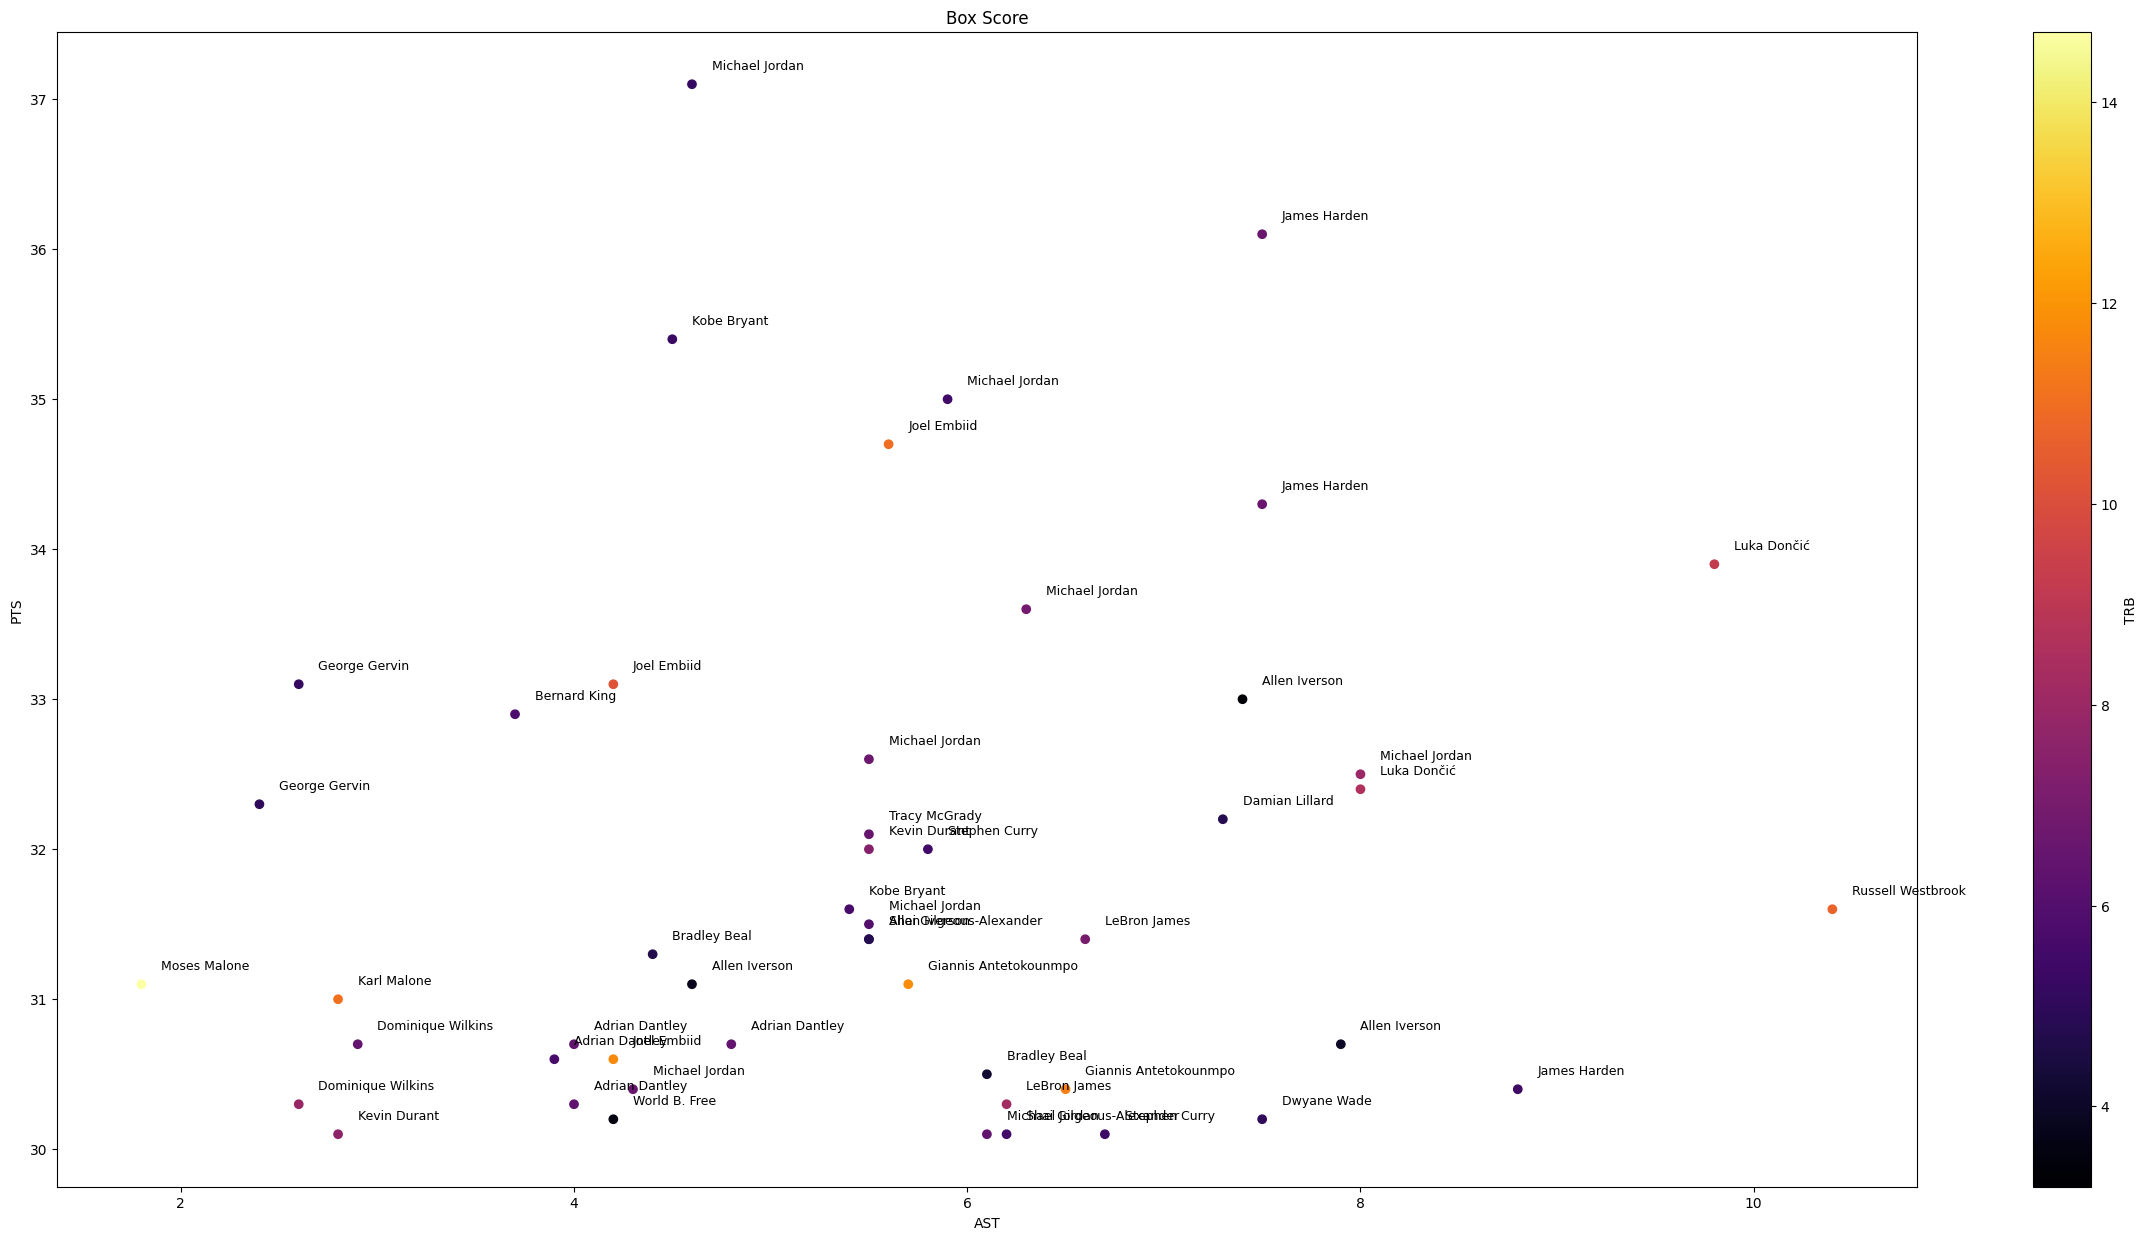

In [ ]:
temp2 = master.sort_values(by='PTS', ascending=False).head(50) .set_index('Player') 


    
fig, ax = plt.subplots(figsize=(30, 15))
scatter = plt.scatter(temp2['AST'], temp2['PTS'], c=temp2['TRB'], cmap='inferno') 
plt.colorbar(scatter, label='TRB')

for i, player in enumerate(temp2.index):
    plt.annotate(player, (temp2['AST'][i]+0.1, temp2['PTS'][i]+0.1), size=9)

plt.xlabel("AST") 
plt.ylabel("PTS")
plt.title("Box Score")
plt.show() 

In [ ]:
temp2 = master[(master['Accurate']==False)|(master['AS_Pred']==True)].set_index('Player') 

fig, ax = plt.subplots(figsize=(30, 15))
scatter = plt.scatter(temp2['PTS'], temp2['AST'], c=temp2["Accurate"], cmap="prism") 
# plt.colorbar(scatter, label="AS_Pred")

for i, player in enumerate(temp2.index):
    plt.annotate(player, (temp2['PTS'][i]+0.1, temp2['AST'][i]+0.1), size=9)

plt.show() 

KeyError: 'Accurate'

C:\Users\bchan\AppData\Local\Temp\ipykernel_14964\1625067521.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(player, (temp3['DRtg'][i]+0.1, temp3['ORtg'][i]+0.1), size=9)


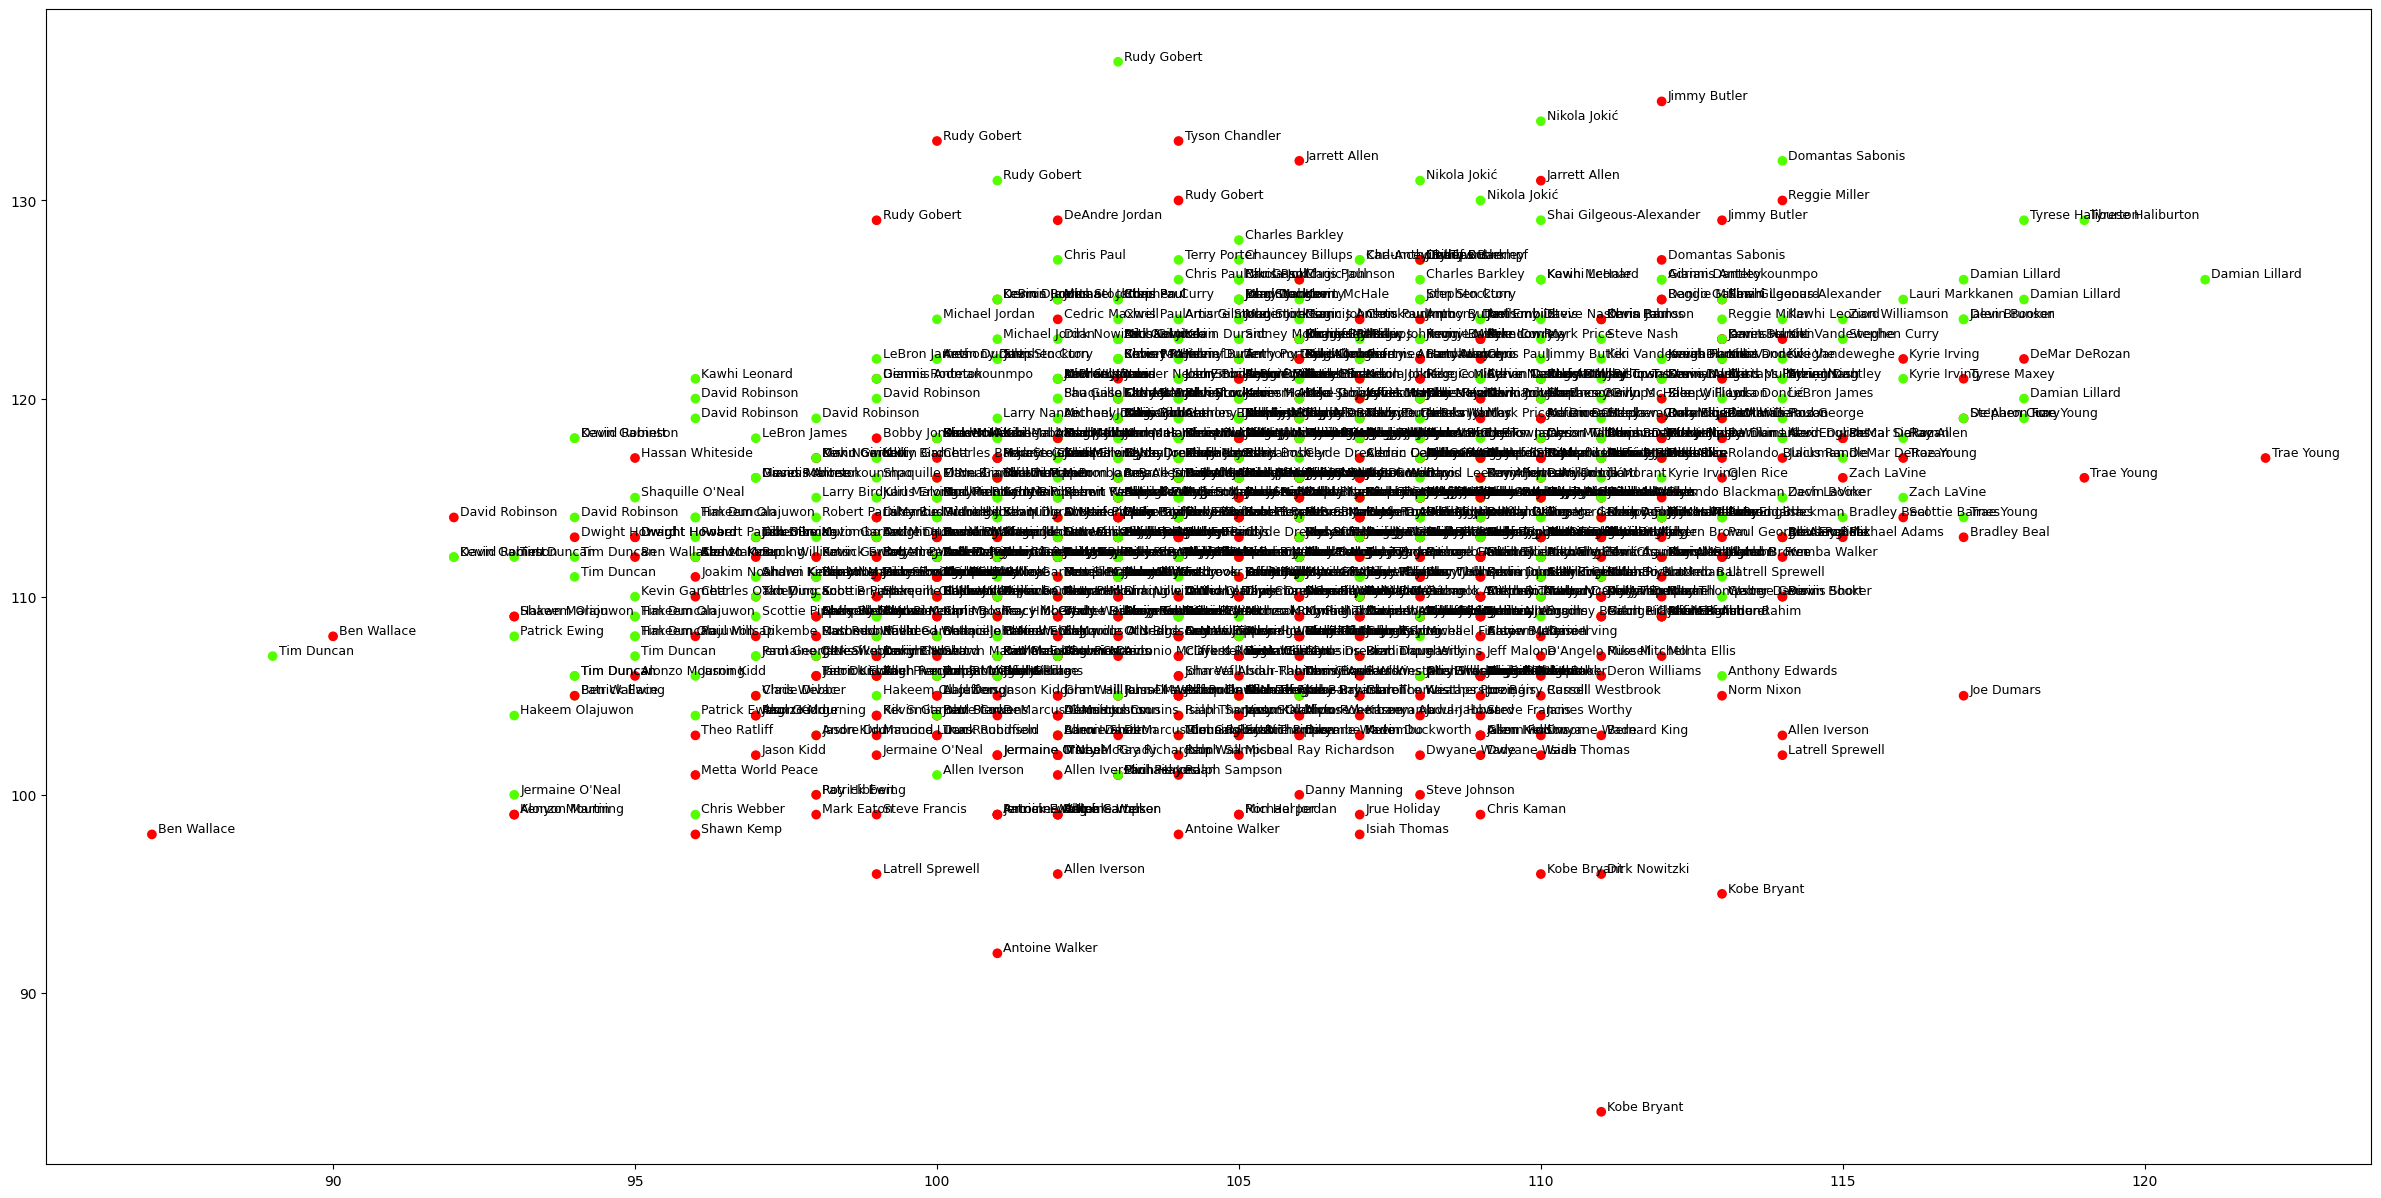

In [ ]:
fig, ax = plt.subplots(figsize=(30, 15))
scatter = plt.scatter(temp3['DRtg'], temp3['ORtg'], c=temp3["Accurate"], cmap="prism") 

for i, player in enumerate(temp3.index):
    plt.annotate(player, (temp3['DRtg'][i]+0.1, temp3['ORtg'][i]+0.1), size=9)

plt.show() 

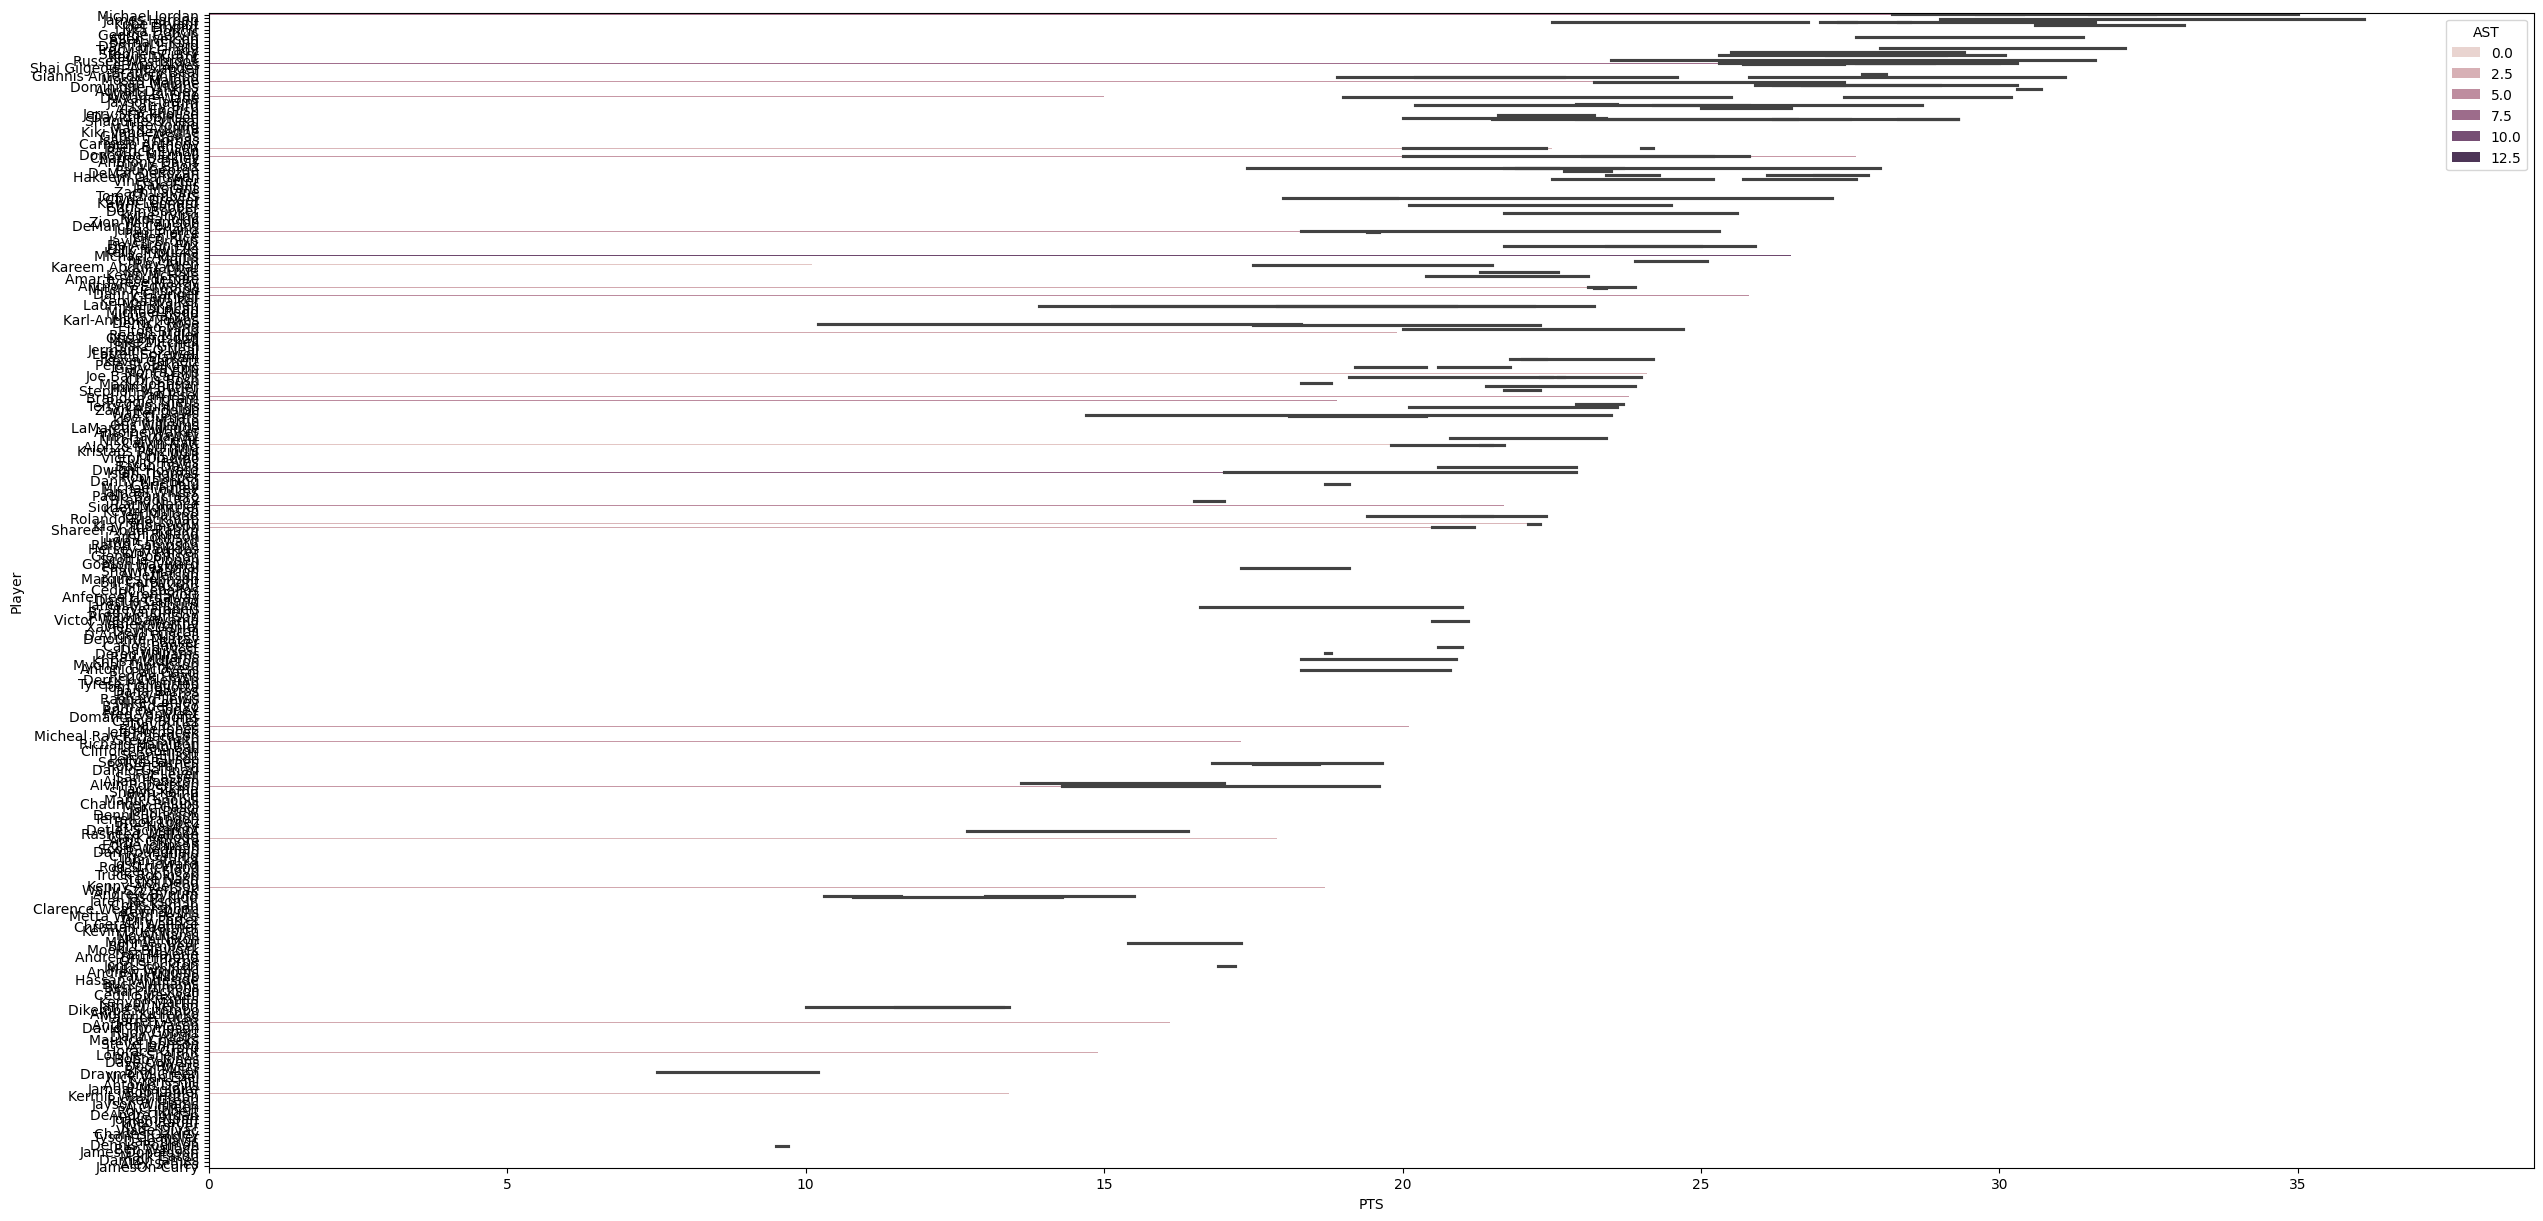

In [ ]:
fig, ax = plt.subplots(figsize=(30, 15))
temp4 = temp2.sort_values(by='PTS', ascending=False)
sns.barplot(data=temp4, x='PTS', y='Player', hue='AST')

plt.show() 

<Axes: xlabel='PTS', ylabel='Count'>

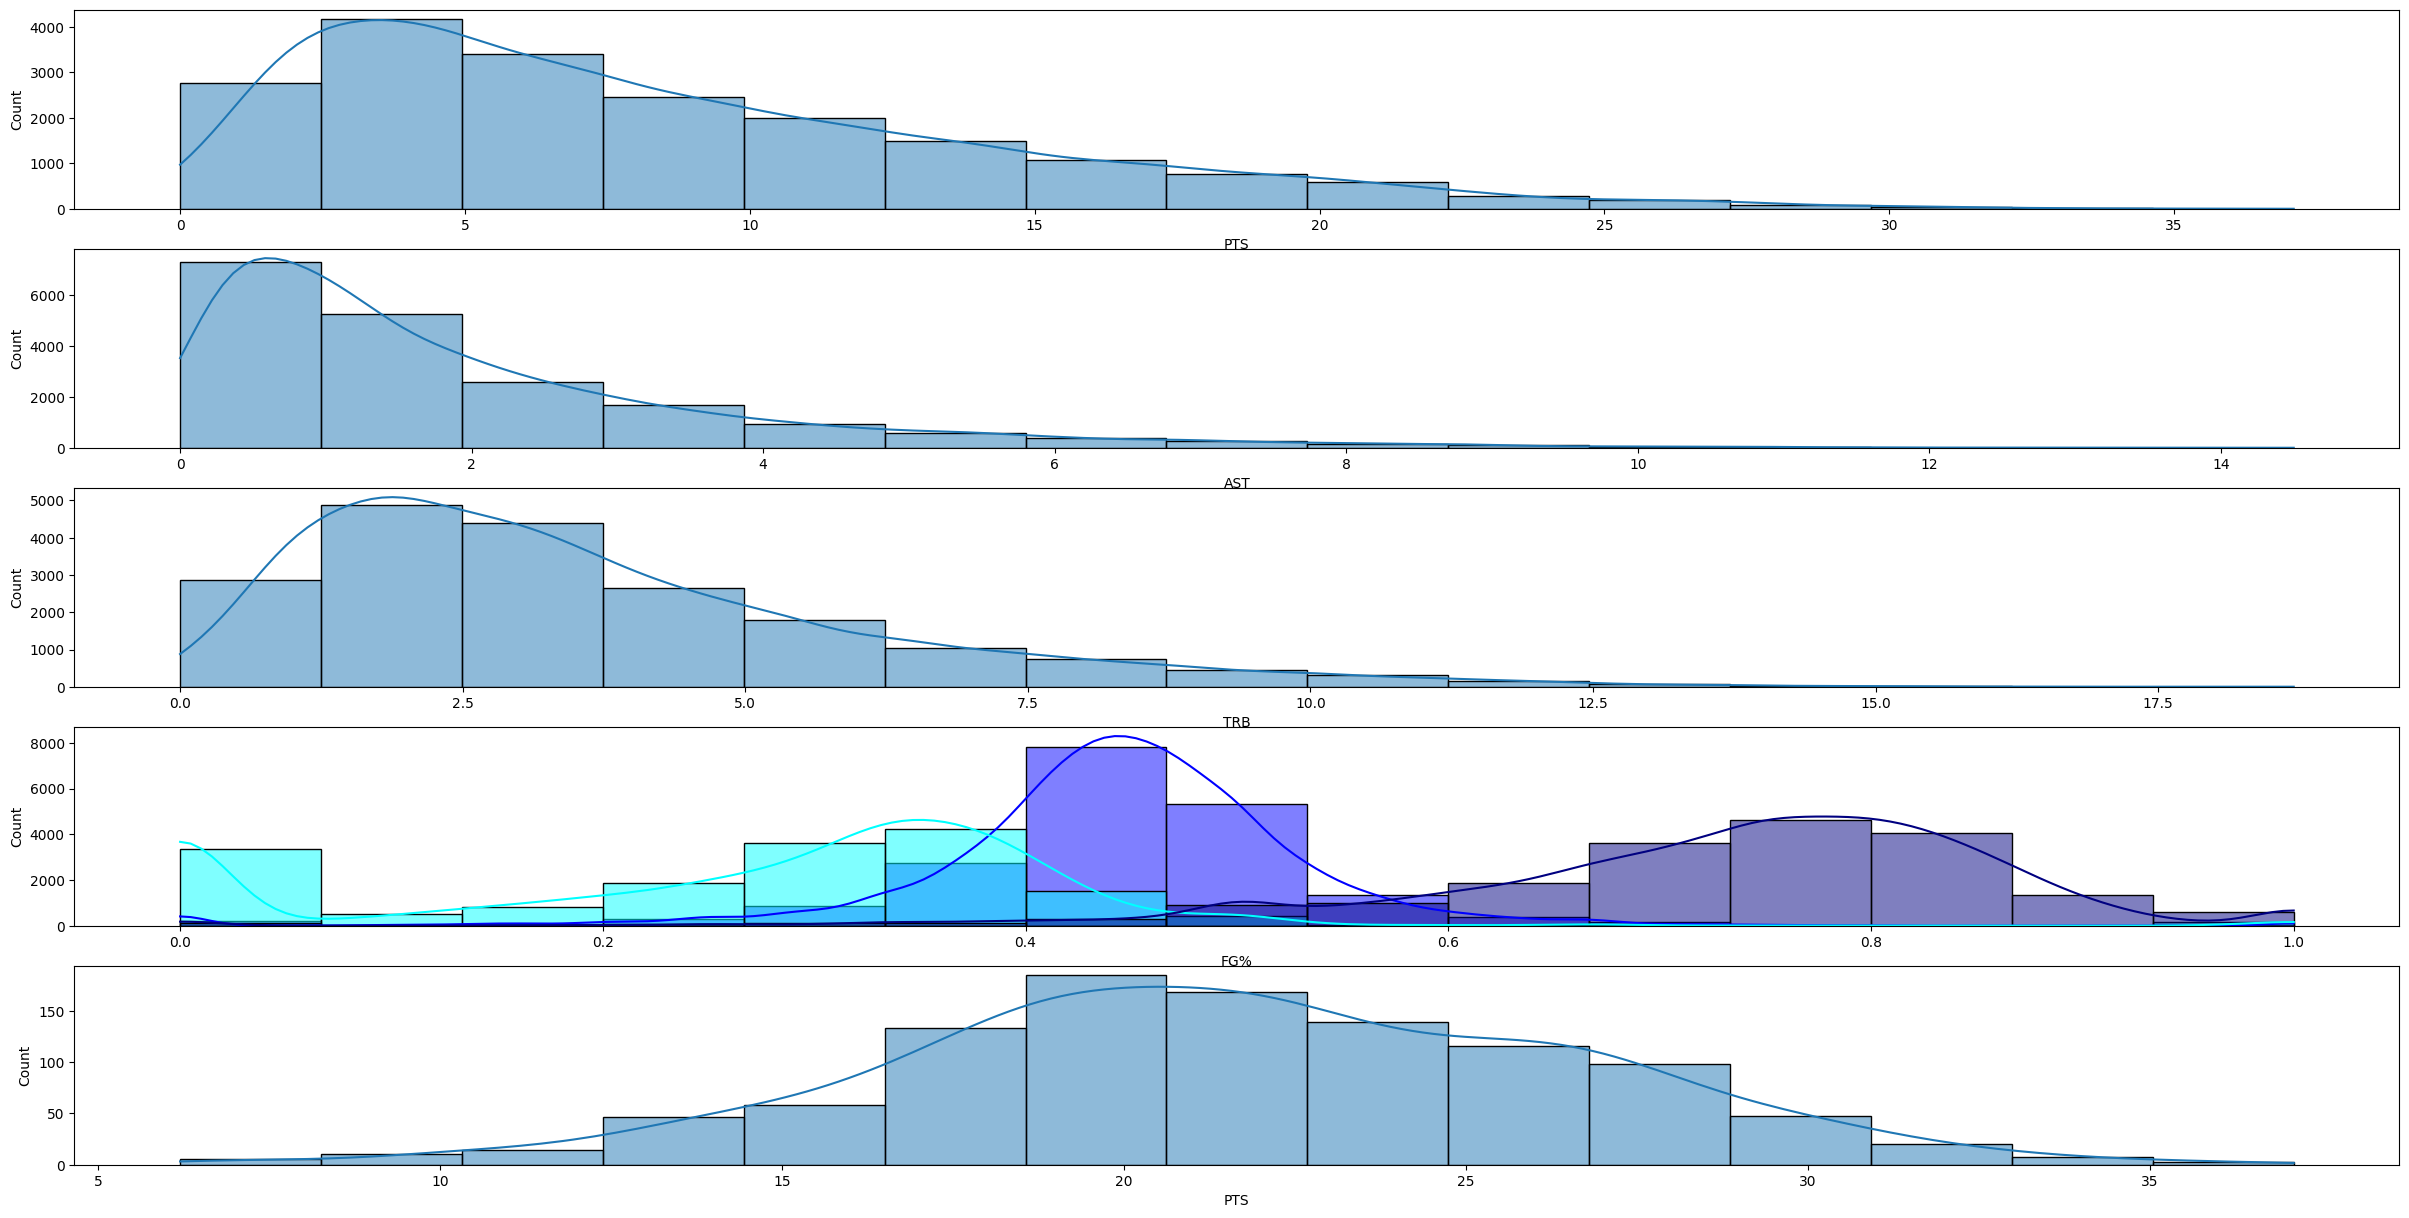

In [ ]:
is_allstar = master[master['AS']==True] 

fig, ax = plt.subplots(figsize=(30, 15), nrows=5)
sns.histplot(master['PTS'], kde=True, bins=15, ax=ax[0]) 
sns.histplot(master['AST'], kde=True, bins=15, ax=ax[1]) 
sns.histplot(master['TRB'], kde=True, bins=15, ax=ax[2]) 
sns.histplot(master['FG%'], kde=True, bins=15, ax=ax[3], color='blue') 
sns.histplot(master['3P%'], kde=True, bins=15, ax=ax[3], color='cyan') 
sns.histplot(master['FT%'], kde=True, bins=15, ax=ax[3], color='navy') 
sns.histplot(is_allstar['PTS'], kde=True, bins=15, ax=ax[4])

## Conclusions 